## Определение стоимости автомобиля
### Вы - компания стартап, помогающая определять цену на старые автомобили, для этого у вас есть набор данных из четырех признаков, в качестве метрики выступае MAE(средняя абсолютная ошибка), MAE должна составлять менее 2.5 тысяч

#### Задачи: 
1. Построете модель прогнозирования цен на автомобили для дальнейшей интеграция ее в приложение FastAPI
2. Реализуйте конечную точку для добавления пользователя в базу данных
3. Реализуйте конечную точку для добавления автомобиля пользователю
4. Реализуйте конечную точку которая вернет пользователю его автомобили выставленные на продажу
5. Реализуйте конечную точку в приложении которая вернет данные о зарегистрированных пользователях
6. Реализуйте конечную точку в приложении для прогнозирования цен на автомобили.
7. Реализуйте конечную точку в приложении чтобы пользователь мог обновить цену на свой автомобиль


**Данные:**
- `fuel-type` - тип топлива
- `num-of-cylinders` - количество цилиндров
- `num-of-doors` - количество дверей
- `horsepower` - количество лошадиных сил
- `price` - цена, рубли

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib
import sqlite3
pd.set_option('display.max_columns', 30)

### 1. Знакомство с данными

In [2]:
#загрузим данные
data = pd.read_csv('autos_app.csv', 
                   engine='pyarrow', 
                   usecols=['fuel-type', 'num-of-cylinders', 
                            'num-of-doors', 'horsepower', 
                            'price'])
data.head()

,fuel-type,num-of-cylinders,num-of-doors,horsepower,price
0,gas,four,two,111.0,13495.0
1,gas,four,two,111.0,16500.0
2,gas,six,two,154.0,16500.0
3,gas,four,four,102.0,13950.0
4,gas,five,four,115.0,17450.0


In [3]:
def eda(data):
    print(f'Размер таблицы: {data.shape}')
    print(f'Типы данных: \n{data.dtypes}')
    print(f'Пропусков в данных: \n{data.isna().sum()}')
    display(data.describe())
    for column in data.columns:
        plt.title(f'{column}')
        plt.grid()
        sns.histplot(data[column], legend=True)
        plt.show()

Размер таблицы: (205, 5)
Типы данных: 
fuel-type            object
num-of-cylinders     object
num-of-doors         object
horsepower          float64
price               float64
dtype: object
Пропусков в данных: 
fuel-type           0
num-of-cylinders    0
num-of-doors        0
horsepower          2
price               4
dtype: int64


,horsepower,price
count,203.000000,201.000000
mean,104.256158,13207.129353
std,39.714369,7947.066342
min,48.000000,5118.000000
25%,70.000000,7775.000000
50%,95.000000,10295.000000
75%,116.000000,16500.000000
max,288.000000,45400.000000


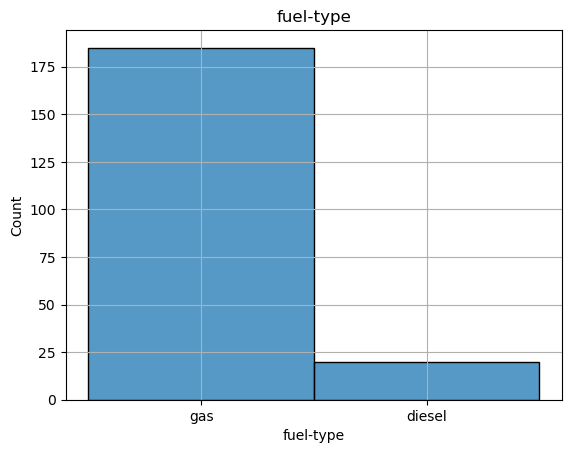

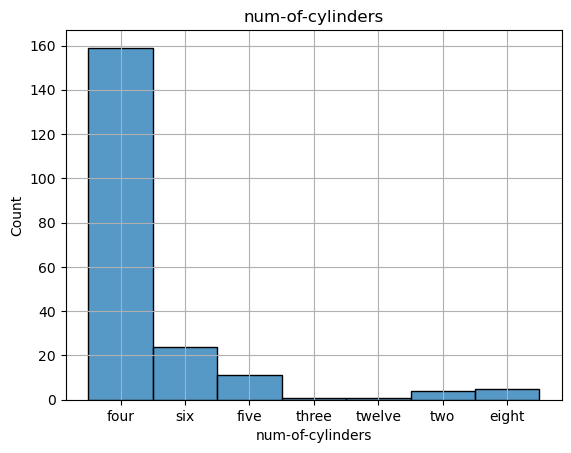

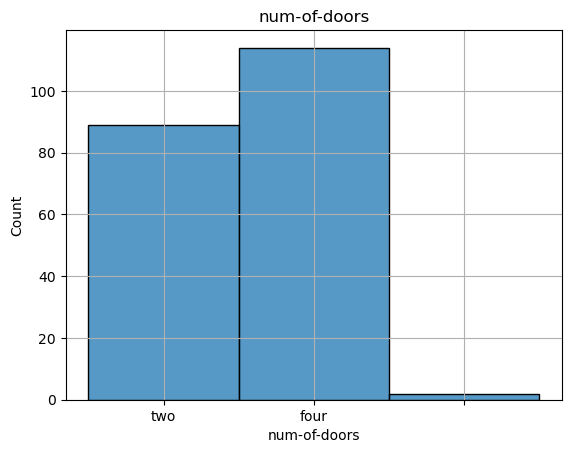

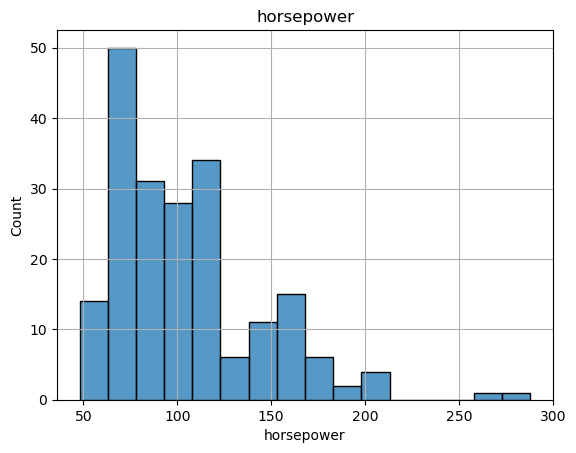

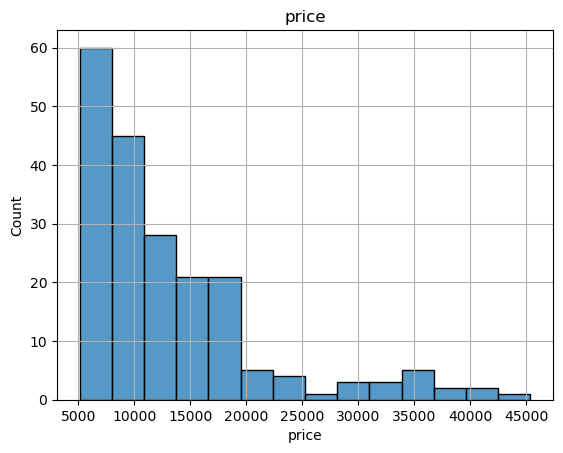

In [4]:
eda(data)

### Вывод:
- Познакомились с данными:
    - 205 объектов и 4 признака + целевой для каждого
    - Присутствуют пропуски в признаке horsepower и в целевом, нужно разбираться в причинах их появления
    - Тип топлива в нашем случае бензин и дизель(автомо на бензине больше чем на авто на дизеле)
    - Присутствуют автомобили с двумя, тремя, четырьмя(самый распространенный класс), пятью, шестью, восьмью и двенадцатью цилиндрами
    - Присутствуют автомобили с двумя или четырьмя дверями, так же объекты не имеющие названия, их немного предлагаю удалить
    - По лошодиным силам особо ничего не выделить, пристутствуют авто с мощность более 250, основная часть автомобилей до 150
    - В признаке цена 75% авто продается по цене до 20 тысяч, максимальная цена за авто 45 тысяч

In [5]:
#уберем объекты с пропусками
data = data[~data['price'].isna()].copy()

#уберем пустое значение
data = data[data['num-of-doors'] != ''].copy()

#заполним пропускм в признаки л.с
data['horsepower'].fillna(data['horsepower'].mean(), inplace=True)


#проверим
data.isna().sum()

fuel-type           0
num-of-cylinders    0
num-of-doors        0
horsepower          0
price               0
dtype: int64

In [6]:
#заменим на числа
data.replace({'gas': 1, 'diesel':0,
              'four': 4, 'six': 6, 
              'two': 2, 'eight': 8, 
              'three': 3, 'twelve': 12, 
              'five': 5}, inplace=True)

#проверим
print(data['fuel-type'].unique())
print(data['num-of-cylinders'].unique())
print(data['num-of-doors'].unique())

[1 0]
[ 4  6  5  3 12  2  8]
[2 4]


### 2. Построение модели

In [7]:
#разделям данные для обучения и валидации
size = len(data)//2
data = shuffle(data, random_state=1)

train = data[:size].copy()
valid = data[size:].copy()

train.shape, valid.shape

((99, 5), (100, 5))

In [8]:
def make_predict(train, valid, model):
    train = train.copy()
    valid = valid.copy()
    
    X_train = train.drop('price', axis=1)
    y_train = train['price']
        
    X_valid = valid.drop('price', axis=1)
    y_valid = valid['price']
    model = model
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = mean_absolute_error(y_valid, y_pred)
    return score

In [9]:
make_predict(train, valid, DecisionTreeRegressor(random_state=1, max_depth=3))

2735.6094130591637

In [10]:
make_predict(train, valid, RandomForestRegressor(random_state=1, max_depth=3))

2641.443212624781

#### Вывод:
|**Model**  |**MAE**|    
|:---|:---:|
|DecisionTree|**2.735**|
|RandomForest|**2.641**|

**Оставим лес и попытаемся настроить с помощью поиска по сетке**

In [11]:
def get_params(train, model):
    
    train = train.copy()
    
    X_train = train.drop('price', axis=1)
    y_train = train['price']
    
    param_grid={'max_depth':[2, 3, 4, 5, 6],
            'n_estimators':[100, 200, 300]}

    grid = GridSearchCV(model, param_grid=param_grid, cv=2, scoring='neg_mean_absolute_error', verbose=1)
    grid.fit(X_train, y_train)
    
    return grid.best_params_

In [12]:
result = get_params(train, RandomForestRegressor(random_state=1, n_jobs=-1))
result

Fitting 2 folds for each of 15 candidates, totalling 30 fits


{'max_depth': 5, 'n_estimators': 300}

In [13]:
make_predict(train, valid, RandomForestRegressor(random_state=1, n_jobs=-1, **result))

2261.1526174132923

In [14]:
data.columns

Index(['fuel-type', 'num-of-cylinders', 'num-of-doors', 'horsepower', 'price'], dtype='object')

In [15]:
def save_model(model, name):
    X = data.drop('price', axis=1).to_numpy()
    y = data['price']
    model = model
    model.fit(X, y)
    joblib.dump(model, f'{name}.pkl')
    return 'Ok_save_model'

save_model(RandomForestRegressor(random_state=1, **result, n_jobs=-1), 'rf_model_total')

'Ok_save_model'

### Summary:
- Попробовали две модели: дерево решений и случайный лес
|**Model**  |**MAE**|    
|:---|:---:|
|DecisionTree|2.735|
|RandomForest|2.641|
|**RandomForest_total**|**2.261**|

- Выбрали модель случайный лес так как средняя абсолютная ошибка у этой модели меньше, сама модель более устойчива к изменениям в данных по сравнению с деревор решений
- Подобрали гиперпараметры
- Так же нужно разбираться в причинах появления пропусков в данных